In [4]:
include("../src/SphereIFSCalib.jl")
using TwoDimensional, Zygote,StatsBase, Plots
gr();

In [5]:
# wavelengths
const λ1 = 987.72e-9# laser 1 
const λ2 = 1123.71e-9# laser 2 
const λ3 = 1309.37e-9# laser 3
const λ4 = 1545.10e-9  # laser 4  
const λlaser = [λ1,λ2,λ3,λ4]
const λ0 = mean(λlaser);# reference


In [6]:
# model of the LensletModel
bbox = BoundingBox(xmin=1, ymin=1, xmax=10, ymax=50);
a0= rand(Float64,4);
fwhm0= rand(Float64,4)*10;
laser =  LaserModel(λlaser,a0,fwhm0)
lmod = LensletModel(λ0,laser,bbox);



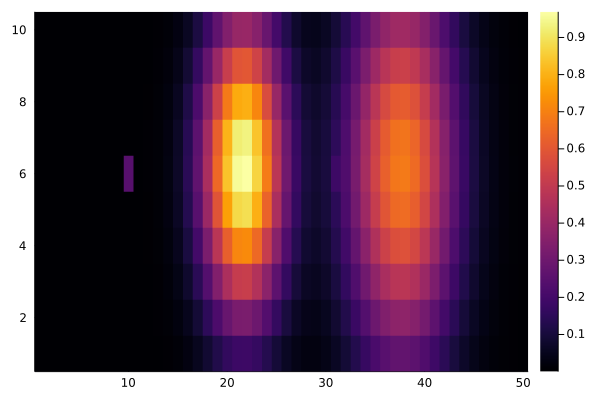

In [7]:
Cinit = [[ 6.2 0 0 0 ]; [25 5e7 0 0]]
UpdateDispModel(lmod.dmodel,Cinit)
limage = LensletLaserImage(lmod,laser)
heatmap(limage)

In [9]:
function  likelihood(a::Array{Float64,1},fwhm::Array{Float64,1},C::Array{Float64,2}) 
    UpdateDispModel(lmod.dmodel, C);
    UpdateLaserModel(laser,a,fwhm);
    return sum((data .- LensletLaserImage(lmod,laser)).^2)
end

data= limage ;
cost = likelihood(a0,fwhm0,Cinit)


0.0

In [10]:
∇cost = gradient(likelihood,a0,fwhm0,Cinit)


([0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])

In [11]:
∇cost = gradient(likelihood,a0,fwhm0 .+ 2.,Cinit)


([15.04826417050361, 2.1883351280463668, 19.499909932898476, 5.103948560059677], [1.6042771065369854, 0.12955826891696073, 3.550084323256175, 1.9758039485829704], [-0.7756514594160497 -5.270201185075161e-8 -1.3457098625939908e-14 -6.364452032101017e-21; -0.1126465076221545 -1.5316379973357878e-7 -3.026988262724951e-14 -8.135734736737857e-21])